# MIMIQ demo - The Heisenberg XXZ Model and KPZ Universality
QPerfect 2025 https://qperfect.io/

The interactive version of this demo can be found at

## Introduction and context
At the forefront of computational physics lies the "many-body problem" - a class of challenges that describe the behavior of matter and materials. This problem is not only one of the most computationally demanding in physics but is also likely to be the first arena where quantum computers demonstrate superiority over classical ones. For quantum simulation, a quantum advantage is achieved when a quantum computer can compute relevant quantities (e.g., magnetism, universal critical exponents) with a precision and accuracy better than any known classical methods.

In 2024, Google Quantum AI and Collaborators published a study on the dynamics of the Heisenberg XXZ model [https://doi.org/10.1126/science.adi7877], a model for describing quantum magnets. Their experiments used a 46 qubit quantum computer to sample output states produced by a deep and wide quantum circuit of alternating layers of 2-qubit Fermionic Simulation "fSim" gates, one of the highest fidelity gates available on the Google device. They observe the mean and variance of the transferred magnetisation exhibits characteristic powerlaws as a function of system size in agreement with the expected Kardar-Parisi-Zhang (KPZ) universality class. However higher moments revealed deviations from the KPZ predictions, hinting at the possibility of new physics.

In this demo, we'll use MIMIQ to simulate the same Heisenberg XXZ model up to 46 qubits - a feat that significantly surpasses what was possible using other simulators, including in the original paper using a high-end NVIDIA GPU cluster. This demonstration underscores MIMIQ's potential for simulating novel physics and verifying quantum computations beyond the limits of traditional methods.

### The Heisenberg XXZ Model: A Closer Look

The model we're investigating is the one-dimensional (1D) XXZ model, which describes nearest-neighbor exchange interactions between spin-1/2 particles. The Hamiltonian is given by:

$$H = \sum_i (S_i^x S_{i+1}^x + S_i^y S_{i+1}^y+ \Delta S_i^z S_{i+1}^z)$$

Here, $S_i^x, S_i^y, S_i^z$ represent single-site spin operators, and $\Delta$ is the anisotropy parameter.

Our experiment involves simulating this model using a 1D chain of spins (qubits) subject to periodic applications of unitary $\text{fSim}(\theta,\phi)$ gates. This includes:

1. Initial State: We start with a product state where the left and right halves of the spin chain have average magnetizations of $\pm \tanh(\mu)$. As $\mu \rightarrow \infty$, we approach a pure domain-wall state, while $\mu \rightarrow 0$ leads towards infinite-temperature thermal state.

2. Circuit Structure: The circuit comprises multiple cycles. Each cycle applies fSim gates to all neighboring pairs in the chain, alternating between odd and even bonds. In the limit $\theta, \phi \rightarrow 0$ this is equivalent to the Trotter–Suzuki expansion of the XXZ Hamiltonian, with $\Delta = \sin(\phi/2)/\sin(\theta). The number of qubits is fixed to twice the number of cycles.

3. Analysis: By examining the output states for various random input states, we extract the statistical moments of the transferred magnetization - essentially, the number of spins that flip from one half of the qubit chain to the other.

### MIMIQ Features used in this demo
- Custom gates
- Batch mode
- Fast sampling

## MIMIQ implementation

Let's begin by importing the necessary packages and establishing a connection to the MIMIQ service.

In [487]:
from mimiqcircuits import *
import matplotlib.pyplot as plt
import random
import numpy as np
from time import sleep

# create a connection to the MIMIQ server
conn = MimiqConnection()
conn.connect()

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 590/10000 minutes
├── Executions: 783/10000
├── Max time limit is: Infinite
├── Default time limit is: 30 minutes
└── status: open

Next, we'll define the fSim (fermionic simulation) gate used by Google in their experiment. This gate is characterized by two parameters: theta and phi.

In [1053]:
def fsim(theta, phi):
    """
    Create a custom fSim (Fermionic Simulation) gate.
    """
    matrix = np.array([
        [1, 0, 0, 0],
        [0, np.cos(theta), -1j*np.sin(theta), 0],
        [0, -1j*np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, np.exp(-1j * phi)]
    ])
    
    return GateCustom(matrix)

We'll also create functions to initialize the quantum state mimicking the initial conditions of the Google experiment and construct the corresponding circuit.

In [1079]:
def build0(nqubits, ncycles, fsim_gate):
    """
    Build the quantum circuit for the XXZ model simulation
    assuming a pure domain wall initial state (mu = infty)
    """
    circ = Circuit()
    
    # prepare initial state
    circ.push(GateX(), range(nqubits//2))
    
    # force MIMIQ to simulate the full chain
    circ.push(GateID(), nqubits)
    
    for _ in range(ncycles):
        # Apply fSim gates to even-odd pairs
        for j in range(0, nqubits - 1, 2):
            circ.push(fsim_gate, j, j+1)
        # Apply fSim gates to odd-even pairs
        for j in range(1, nqubits - 1, 2):
            circ.push(fsim_gate, j, j+1)

    return circ

Now we're ready to perform our simulation. We'll use the same parameters as those in Figure 1 of the Google paper, allowing for a direct comparison of results for a pure domain wall ($\mu = \infty$). Below we build a list of circuits, each for a different number of cycles up to 23.

In [1080]:
theta, phi = 0.4*np.pi, 0.8*np.pi
nqubits = 46
circuits = [build0(nqubits, t, fsim(theta,phi)) for t in range(24)]

This returns a list of 24 circuits, each representing a different number of cycles from 0 to 23. To efficiently process these, we'll leverage MIMIQ's batch mode capability. To ensure the accuracy of our simulation, we'll explicitly set the bond dimension, which controls the amount of entanglement that can be represented in the simulation. A higher bond dimension generally leads to more accurate results but can increase the run time. After running the simulations, we'll print the fidelity estimates for each circuit to check the accuracy.

In [1081]:
bonddim = 128
nsamples = 2**12
job = conn.execute(circuits, algorithm="mps", nsamples = nsamples, bonddim=bonddim)

results = conn.get_results(job)

print(" Cycle | Qubits | Fidelity\n", "-" * 28)
for cycle, simulation in enumerate(results):
    nqubits = 2 * cycle
    fidelity = simulation.fidelities[0]
    print(f"{cycle:6d} | {nqubits:6d} | {fidelity:.6f}")

 Cycle | Qubits | Fidelity
 ----------------------------
     0 |      0 | 1.000000
     1 |      2 | 1.000000
     2 |      4 | 1.000000
     3 |      6 | 1.000000
     4 |      8 | 1.000000
     5 |     10 | 1.000000
     6 |     12 | 1.000000
     7 |     14 | 1.000000
     8 |     16 | 0.996208
     9 |     18 | 0.996207
    10 |     20 | 0.996181
    11 |     22 | 0.995038
    12 |     24 | 0.994884
    13 |     26 | 0.994762
    14 |     28 | 0.994314
    15 |     30 | 0.993781
    16 |     32 | 0.993322
    17 |     34 | 0.992665
    18 |     36 | 0.992001
    19 |     38 | 0.991365
    20 |     40 | 0.990076
    21 |     42 | 0.988211
    22 |     44 | 0.986008
    23 |     46 | 0.981561


Our simulations show fidelities very close to 1, decreasing slightly for larger cycle numbers. This high fidelity indicates the accuracy of our simulation. If you wish to extend the simulation even further, you may want to increase the bond dimension even more.

## Reproducing some plots from the paper

Lets visualize the samples from each cycle.

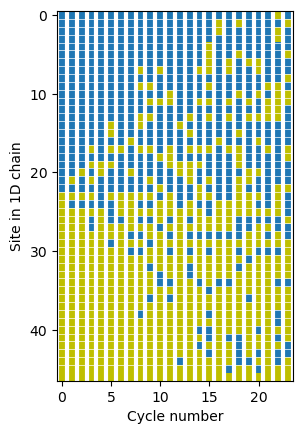

In [1082]:
# Choose at random one sample from each simulation
bitstrings = [random.choice(simulation.cstates).to01() for simulation in results]
mz = np.array([list(s) for s in bitstrings], dtype=int)

# Create a custom colormap
from matplotlib.colors import LinearSegmentedColormap
my_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#BFBF00', '#1F77B4'])

# Create the plot
plt.imshow(np.transpose(mz), cmap=my_cmap)
for y in range(46):
    if y<=24:
        plt.axvline(x=y-0.5, color='white', linestyle='-', linewidth=3)
    plt.axhline(y=y-0.5, color='white', linestyle='-', linewidth=0.5)

plt.gca().set_aspect(0.8) 
plt.xlabel("Cycle number")
plt.ylabel("Site in 1D chain");

Lets take a look at the probability distribution of transferred magnetization after t = 1, 5 and 20 cycles. This can be directly compared with figure 1c in the paper. First we will define a simple function to extract the transferred magnetisation.

In [1087]:
def transferred_magnetisation_inf(samples):
    """
    Calculate the transferred magnetisation for each
    sample assuming a pure domain wall initial state
    """
    nq = len(samples[0])
    mid = nq // 2
    init_right_sum = 0

    M = np.zeros(len(samples))
    for i,sample in enumerate(samples):
        right_sum = sum(int(bit) for bit in sample[mid:])
        M[i]= 2 * (right_sum - init_right_sum)

    return M

Finally we can plot histograms of the transferred magnetisation for 1, 5 and 20 cycles.

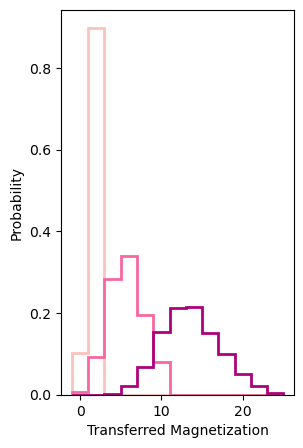

In [1098]:
M1 = transferred_magnetisation_inf(results[1].cstates)
M5 = transferred_magnetisation_inf(results[5].cstates)
M20 = transferred_magnetisation_inf(results[20].cstates)

fig, ax = plt.subplots(figsize=(3, 5))
for data, color in zip([M1, M5, M20], ["#FAC3BE", "#F767A1", "#AD017E"]):
    ax.hist(data, bins=np.arange(-1, 27, 2), histtype='step', linewidth=2, weights=1/nsamples*np.ones_like(data), color=color)
ax.set_xlabel('Transferred Magnetization')
ax.set_ylabel('Probability');

## Going further with MIMIQ

Having successfully reproduced the experimental protocol, we can now try to verify the Kardar-Parisi-Zhang (KPZ) scaling law. This verification requires a statistical analysis across various initial states for finite values of μ. Ordinarily, this would involve numerous simulations with different random initial states, necessitating many job submissions to the MIMIQ servers. However, we can employ a more efficient approach:
- Prepare the initial state in a superposition which depends on the parameter $\mu$.
- Use Measure instructions before and after applying the circuit.
    - The first Measure instruction will prepare the initial product state and record it to the first $n$ bits of the classical register
    - The second Measure instruction will record the final states to the last $n$ bits of the classical register.

In [1099]:
def build(nqubits, ncycles, fsim_gate, mu):
    """
    Build the full quantum circuit for the XXZ model simulation
    
    Initialization is performed by preparing the qubits in a superposition state
    followed by Measure instruction.
    """
    circ = Circuit()

    # calculate rotation angle
    Sz = np.tanh(mu)
    theta = 2 * np.arccos(np.sqrt((1 - Sz) / 2))
    theta2 = -2 * np.arccos(np.sqrt((1 + Sz) / 2))
    
    # prepare initial superposition state
    circ.push(GateRY(-theta2), range(0,nqubits//2))
    circ.push(GateRY(theta), range(nqubits//2, nqubits))

    # measure initial state
    circ.push(Measure(), range(nqubits), range(nqubits))

    for _ in range(ncycles):
        # Apply fSim gates to even-odd pairs
        for j in range(0, nqubits - 1, 2):
            circ.push(fsim_gate, j, j+1)
        # Apply fSim gates to odd-even pairs
        for j in range(1, nqubits - 1, 2):
            circ.push(fsim_gate, j, j+1)
    
    # measure final state
    circ.push(Measure(), range(nqubits), range(nqubits, 2*nqubits))

    return circ

### Running the simulations (mu=1.0)
By incorporating Measure instructions, each sample is treated as an independent simulation run. This method allows us to gather a large amount of data in a single execution, though it may take some time to process a high number of samples.

Let's prepare our circuit and execute it on the MIMIQ platform.

In [1100]:
theta = 0.4 * np.pi
phi = 0.8 * np.pi
mu = 1.0
bonddim = 128
nsamples = lambda t: 800 // t # adaptive number of samples

data = []
for t in range(4, 24):
    nqubits = 2 * t
    circuits = build(nqubits, t, fsim(theta, phi), mu)
    job = conn.execute(
        circuits,
        algorithm="mps",
        nsamples=nsamples(t),
        bonddim=bonddim
    )
    expt = {
        'job': job,
        'cycles': t,
        'bonddim': bonddim,
        'samples': nsamples(t),
        'nqubits': nqubits,
        'mu': mu,
        'theta': theta,
        'phi': phi
    }
    data.append(expt)
    sleep(1)

### Extracting observables
To accommodate our modified approach, we need to create a new function for calculating the transferred magnetization. This function will now base its calculations on both the initial and final bitstrings obtained from our measurements.

In [1101]:
def transferred_magnetization(samples):
    Mz = np.zeros(len(samples))
    
    split = len(samples[0]) // 2
    for i,bs in enumerate(samples):
        initial = bs[:split]
        final = bs[split:]
        mid = len(initial) // 2
        Mz[i] = 2 * (final.to01()[:mid].count('1') - initial.to01()[:mid].count('1'))
    return Mz

Once the simulations are complete we'll retrieve the results and generate a detailed report.

In [1104]:
def process_experiment(conn, expt):
    if not conn.isJobDone(expt['job']):
        expt['done'] = False
        return expt

    results = conn.get_result(expt['job'])
    return {
        **expt,
        'done': True,
        'fidelities': results.fidelities,
        'Mz': transferred_magnetization(results.cstates),
        'runtimes': results.timings['total']
    }

data = [process_experiment(conn, expt) for expt in data]

print(f"{'Cycles':>6} {'Fid':>8} {'Mean Mz':>10} {'Var Mz':>10} {'Runtime':>10} {'Trials':>8}")
print("-" * 60)
for expt in data:
    if expt['done']:
        print(f"{expt['cycles']:6d} {np.mean(expt['fidelities']):8.4f} "
              f"{np.mean(expt['Mz']):10.4f} {np.var(expt['Mz']):10.4f} "
              f"{np.mean(expt['runtimes']):10.4f} {len(expt['Mz']):8d}")

Cycles      Fid    Mean Mz     Var Mz    Runtime   Trials
------------------------------------------------------------
     4   1.0000     3.9600     5.2784     0.3235      200
     5   1.0000     4.5625     5.5086     0.9066      160
     6   1.0000     5.2481     4.7881     1.7418      133
     7   1.0000     6.1228     6.9674     8.2042      114
     8   0.9988     6.4600     7.1084    30.4813      100
     9   0.9857     6.7273     8.2893   102.2527       88
    10   0.9852     7.4000     7.6400   155.9567       80
    11   0.9683     8.1667    10.5278   287.4743       72
    12   0.9661     8.8182     9.3306   341.6125       66
    13   0.9242     8.3934     7.1895   482.8892       61
    14   0.9301     8.7368     9.3518   543.3167       57
    15   0.8886     9.4340     8.6607   733.4767       53
    16   0.8417     8.4800    10.3296   822.1937       50
    17   0.8218    10.2128    12.1249  1014.0792       47
    18   0.7656     9.9545     9.9070  1078.3841       44
    19   0.

### Plot the data and compare with the original experiments

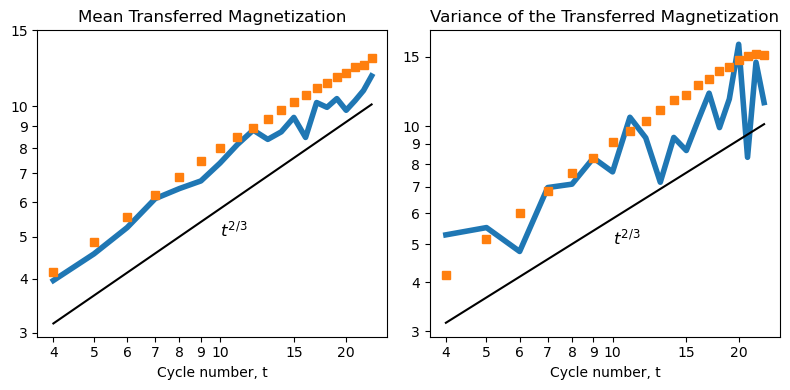

In [1106]:
# generate arrays
cycles = [expt['cycles'] for expt in data if expt['done']]
meanM = [np.mean(expt['Mz']) for expt in data if expt['done']]
varM = [np.var(expt['Mz']) for expt in data if expt['done']]

# Google's experiments for the mean and variance
# https://zenodo.org/records/10957534
mean_google = [4.13764503e+00, 4.86157089e+00, 5.53853615e+00, 6.25599039e+00,
               6.86650431e+00, 7.47127230e+00, 8.01175521e+00, 8.49793481e+00,
               8.91637586e+00, 9.35459297e+00, 9.80771573e+00, 1.02247414e+01,
               1.06550979e+01, 1.10051316e+01, 1.13353823e+01, 1.17048219e+01,
               1.19527548e+01, 1.23273715e+01, 1.24908791e+01, 1.29423539e+01]

var_google = [ 4.16691574e+00, 5.13637533e+00, 5.99239447e+00, 6.81448950e+00,
               7.57429554e+00, 8.30211450e+00, 9.09801946e+00, 9.73519956e+00,
               1.03150800e+01, 1.09799737e+01, 1.16172881e+01, 1.20237727e+01,
               1.27507625e+01, 1.31558716e+01, 1.38362763e+01, 1.41206288e+01,
               1.46993168e+01, 1.50762525e+01, 1.52515802e+01, 1.51641930e+01]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# First subplot
ax1.loglog(cycles, meanM, lw=4)
ax1.loglog(range(4,24), mean_google, 's')
ax1.set_title("Mean Transferred Magnetization")

ax2.loglog(cycles, varM, lw=4)
ax2.loglog(range(4,24), var_google, 's')
ax2.set_title("Variance of the Transferred Magnetization")

for ax in [ax1,ax2]:
    ax.text(10, 5, '$t^{2/3}$', fontsize=12, color='black')
    ax.loglog(cycles, 1.25*np.array(cycles)**(2/3), '-k')
    ax.set_xticks([4,5,6,7,8,9,10,15,20])
    ax.set_xticklabels([4,5,6,7,8,9,10,15,20])
    ax.set_xlabel('Cycle number, t')
    ax.set_yticks([3,4,5,6,7,8,9,10,15])
    ax.set_yticklabels([3,4,5,6,7,8,9,10,15])
plt.tight_layout()

The simulations confirm that the mean transferred magnetization and variance closely follow the expected KPZ scaling of $t^{2/3}$ within sampling precision, aligning with the experiments reported in the Google paper (orange squares). We note that the experimental data appears slightly shifted up compared to the simulations, which upon closer inspection can also be seen in the exact simulataions presented in the paper. The estimated fidelity of the simulations gradually decreases with cycle number, reaching approximately 0.5 for the largest problem size (23 cycles = 46 qubits), without significantly impacting the observables. Compared to the Google paper, these simulations are substantially faster, typically taking minutes to run versus several hours on a large-scale GPU based statevector simulator, with minimal accuracy loss.

MIMIQ's capabilities extend beyond this challenging many-body problem, which combines high entanglement with non-trivial observables. We encourage you to explore further using MIMIQ. For example, with MIMIQ you can:
- Analyze of various quantum observables and their higher-order moments
- Investigate of different quantum models, including higher-dimensional systems
- Explore of time-dependent quantum problems
- Study disorder effects and relaxation dynamics in quantum systems
- Simulate and compare both ideal and noisy quantum circuits
By leveraging MIMIQ's advanced features, you can validate theoretical models, discover potential new universality classes, and develop insights into complex quantum systems, pushing the boundaries in many-body physics, quantum simulation, and quantum computing.